In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os, sys, pickle, copy, pygmt, operator

from pathlib import Path
from time import sleep
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

import seaborn as sns; sns.set()
sns.set_theme(style="white")

#from joblib import Parallel, delayed
#import multiprocessing
#import numba as nb
#from numba import jit

from sklearn.feature_selection import RFECV,RFE
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

from sklearn.metrics import make_scorer ,explained_variance_score, mean_absolute_error, mean_squared_error, \
r2_score, max_error, median_absolute_error, mean_absolute_percentage_error


from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.compose import make_column_selector as selector
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import PowerTransformer, OrdinalEncoder


In [3]:
# constanst
crs_to='epsg:4326'
crs_from='epsg:4326'
projection = 'M5.4i'
#parent directory

DIR = Path().resolve() 

plt_params = {
    'figure.titlesize' : 28,
    "axes.titlesize" : 25, # main
    "axes.labelsize" : 25,  # labels
    "axes.edgecolor" : "black", 
    "axes.linewidth" : 1, 
    'xtick.labelsize': 20, # ticks
    'ytick.labelsize': 20,
    'legend.title_fontsize':17,
    'legend.fontsize': 17,
    'font.size': 20,
}


# We can exclude Arctic ocean and Antarctica, as there are no HF measurements to use
world_lon_min, world_lon_max, world_lat_min, world_lat_max  = -180, 180, -60, 80

# map extents of Africa and Australia
afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max =  -20, 52, -37 , 38  






In [4]:

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [5]:
obs = pd.DataFrame()


obs["OBS_REF"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV","PV", 
            "GEOID","FA","DEM","BG", "EMAG2_CLASS",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST_W", "REG", "GLIM"]

obs["OBS_AFR"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV_Velocity","PV_Velocity", 
            "GEOID","FA","DEM","BG", "EMAG2",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST", "REG", "GLIM"]
  
     
# Labels for plots etc


# Labels for plots etc
obs["LABELS_gmt"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "S@_v@ 150km", "P@_v@ 150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. rho", "Crust rho",  
                 "Volcano", "REG", "GliM", ]  


obs["LABELS"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "$S_v$ @150km", "$P_v$ @150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. ρ", "Crust ρ",  
                 "Volcano", "REG", "GliM", ]
    
# "vp/vs"
# Units to display in plots etc
obs["UNITS"] = ["km",  "si", "km", "km",
             "$\delta$$S_v$ %","$\delta$$P_v$ %", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m$^3$", "kg/m$^3$",
                "km",  "class", "class"]



obs["UNITS_gmt"] = ["km",  "si", "km", "km",
             "km/s","km/s", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m@+3@+", "kg/m@+3@+",
                "km",  "class", "class"]
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs["V_RANGE"] = [(0,50), (-1,1),(0,300),(15,60),
              (-0.075,0.075), (-0.02,0.02), 
              (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-0.4, 0.4), 
                   (3260, 3360), (2650, 2950),
                  (0,1), (1,6),(1,16),]


    
obs["V_RANGE_AFR"] = [(0,50), (-1,1),(50,250),(20,50),
          (-0.075,0.075), (-0.02,0.02), 
          (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-200, 200), 
               (3260, 3360), (2650, 2950),
              (0,100), (1,6),(1,15),]


obs["CMAPS"] = ["batlow",  "broc", "bamako", "batlow", 
             "roma","roma", 
             "bamako", "broc", "bukavu", "broc", "batlow",            
                "batlow", "batlow",
               "bamako",  "batlowS","categorical", ]

obs["CMAPS"] = ["SCM/bamako",  "SCM/broc", "SCM/bamako", "SCM/bamako", 
             "SCM/roma","SCM/roma", 
             "SCM/bamako", "SCM/broc", "SCM/oleron", "SCM/broc", "SCM/bilbao",            
                "SCM/batlow", "SCM/batlow",
               "SCM/broc",  "gmt/categorical","gmt/categorical", ]

new_index = [0,1,2,3,4,5,6,8,7,9,10,11,12,13,14,15]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

obs = obs.reindex(new_index)

#obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 16




obs_dict = obs.to_dict(orient='records')

obs.set_index(['OBS_REF'], inplace=True)



obs

OBS_AFR   LABELS_gmt        LABELS            UNITS  UNITS_gmt          V_RANGE      V_RANGE_AFR            CMAPS
OBS_REF                                                                                                                           
CTD                  CTD          CTD           CTD               km         km          (0, 50)          (0, 50)       SCM/bamako
SI                    SI  Shape index   Shape index               si         si          (-1, 1)          (-1, 1)         SCM/broc
LAB                  LAB          LAB           LAB               km         km         (0, 300)        (50, 250)       SCM/bamako
MOHO                MOHO         Moho          Moho               km         km         (15, 60)         (20, 50)       SCM/bamako
SV           SV_Velocity  S@_v@ 150km  $S_v$ @150km  $\delta$$S_v$ %       km/s  (-0.075, 0.075)  (-0.075, 0.075)         SCM/roma
PV           PV_Velocity  P@_v@ 150km  $P_v$ @150km  $\delta$$P_v$ %       km/s    (-0.02, 0.02)    (-0.02, 0.02)         SCM/roma
GEOID              GEOID        Geoid         Geoid                m          m        (-45, 45)        (-45, 45)       SCM/bamako
DEM                  DEM          DEM           DEM                m          m    (-2200, 2200)    (-2200, 2200)       SCM/oleron
FA                    FA     Free air      Free air             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc
BG                    BG      Bouguer       Bouguer             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc
EMAG2_CLASS        EMAG2         Mag.          Mag.            f(nT)      f(nT)      (-0.4, 0.4)      (-200, 200)       SCM/bilbao
RHO_L              RHO_L    Lith. rho       Lith. ρ         kg/m$^3$  kg/m@+3@+     (3260, 3360)     (3260, 3360)       SCM/batlow
RHO_C              RHO_C    Crust rho       Crust ρ         kg/m$^3$  kg/m@+3@+     (2650, 2950)     (2650, 2950)       SCM/batlow
VOLC_DIST_W    VOLC_DIST      Volcano       Volcano               km         km           (0, 1)         (0, 100)         SCM/broc
REG                  REG          REG           REG            class      class           (1, 6)           (1, 6)  gmt/categorical
GLIM                GLIM         GliM          GliM            class      class          (1, 16)          (1, 15)  gmt/categorical

In [6]:
ds_afr = xr.load_dataset(DIR/'Grids'/'Inputs'/"ds_afr.nc")
#ds_world = xr.load_dataset(dir_p/'Grids'/'inputs'/"ds_world.nc")



In [7]:

target = 'GHF'
coord = ['lon', 'lat']
grid_index_world = 'grid_index_world'
grid_index_afr ='grid_index_afr'

hq_lower_bound = 25
hq_upper_bound = 100


#######

features_ex = []
features_ghf = []



features = obs.index.to_list()



in_features = set(features)

features_ex = copy.deepcopy(features)
features_ex.extend(coord)
features_ex.append(grid_index_world)
features_ex.append(grid_index_afr)

features_ex.append(target)

features_ghf = copy.deepcopy(features)
features_ghf.append(target)


features_ex

['CTD',
 'SI',
 'LAB',
 'MOHO',
 'SV',
 'PV',
 'GEOID',
 'DEM',
 'FA',
 'BG',
 'EMAG2_CLASS',
 'RHO_L',
 'RHO_C',
 'VOLC_DIST_W',
 'REG',
 'GLIM',
 'lon',
 'lat',
 'grid_index_world',
 'grid_index_afr',
 'GHF']

In [8]:


rating = 'ra'
outlier = 'OD'


file_label = f'{outlier}_{rating}'

w_OD_ra_f =  DIR/'Dataset'/'Preprocessed'/f'W_OD_ra.csv'
W_OD_ra = pd.read_csv(w_OD_ra_f, sep='\t')

#mask_afr = W_OD_ra['lon'].between(afr_lon_min, afr_lon_max)& W_OD_ra['lat'].between(afr_lat_min, afr_lat_max)
#Afr_OD_ra = W_OD_ra[~mask_afr]

Afr_OD_ra_f =  DIR/'Dataset'/'Preprocessed'/f'Afr_OD_ra.csv'
Afr_OD_ra = pd.read_csv(Afr_OD_ra_f,  sep='\t')


Afr_NOD_ra_f =  DIR/'Dataset'/'Preprocessed'/f'Afr_NOD_ra.csv'
Afr_NOD_ra = pd.read_csv(Afr_NOD_ra_f,sep='\t')


#######
W_OD_ra['GLIM']  = W_OD_ra['GLIM'].astype('category')
W_OD_ra['REG']  = W_OD_ra['REG'].astype('category')

Afr_OD_ra['GLIM']  = Afr_OD_ra['GLIM'].astype('int').astype('category')
Afr_OD_ra['REG']   = Afr_OD_ra['REG'].astype('int').astype('category')

Afr_NOD_ra['GLIM']  = Afr_NOD_ra['GLIM'].astype('int').astype('category')
Afr_NOD_ra['REG']   = Afr_NOD_ra['REG'].astype('int').astype('category')


#####

X_w = W_OD_ra[features]
y_w = W_OD_ra[target].values.reshape(-1,1) 


X_afr = Afr_OD_ra[features]
y_afr = Afr_OD_ra[target].values.reshape(-1,1) 




bs_rfr_hyp =  DIR/'Hyperparameters'/f'BS_hyperparameter.csv'



bs_rfr_hyp_df = pd.read_csv(bs_rfr_hyp, sep='\t')


best_params = bs_rfr_hyp_df.to_dict('r')[0]

print(file_label)


print(len(Afr_OD_ra))
print(len(W_OD_ra))


X_afr.describe(include='all')

OD_ra
861
5618


CTD          SI         LAB        MOHO          SV          PV       GEOID          DEM          FA          BG  EMAG2_CLASS        RHO_L        RHO_C  VOLC_DIST_W    REG   GLIM
count   861.000000  861.000000  861.000000  861.000000  861.000000  861.000000  861.000000   861.000000  861.000000  861.000000   861.000000   861.000000   861.000000   861.000000  861.0  861.0
unique         NaN         NaN         NaN         NaN         NaN         NaN         NaN          NaN         NaN         NaN          NaN          NaN          NaN          NaN    5.0   11.0
top            NaN         NaN         NaN         NaN         NaN         NaN         NaN          NaN         NaN         NaN          NaN          NaN          NaN          NaN    1.0   16.0
freq           NaN         NaN         NaN         NaN         NaN         NaN         NaN          NaN         NaN         NaN          NaN          NaN          NaN          NaN  405.0  514.0
mean     29.047206    0.042894  131.599482   33.893430    0.020585    0.002124   11.468817   193.259001    4.223703  -16.102082     0.016227  3319.950827  2789.620473     0.005229    NaN    NaN
std       6.040011    0.409558   39.512670    4.992274    0.030874    0.006901   12.112743   679.888988   23.819134   67.301019     0.112239    30.612270    37.245837     0.050981    NaN    NaN
min      21.465931   -0.838243   64.658735   14.861654   -0.074950   -0.019805  -19.335741 -1121.000000  -33.854423 -185.475835    -1.000000  3262.528632  2701.059512     0.000000    NaN    NaN
25%      24.957008   -0.320227   78.421560   30.977838   -0.007629   -0.003520    5.973376  -158.000000  -21.852249  -47.371654    -0.034223  3276.123054  2755.837999     0.000000    NaN    NaN
50%      26.583212    0.076117  144.048585   33.703855    0.034574    0.004356   10.684688   -12.000000    1.837202   11.801308     0.042244  3338.425108  2786.487570     0.000000    NaN    NaN
75%      30.969939    0.259312  163.940223   36.405059    0.044109    0.004684   18.533428   480.000000   21.503816   30.058542     0.065555  3343.299518  2803.624425     0.000000    NaN    NaN
max      56.587565    0.958196  178.464848   48.227529    0.070477    0.029473   54.581686  2537.000000   94.168742  135.872088     0.438907  3371.878973  2888.931047     0.821886    NaN    NaN

In [9]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    
    y_true = y_true.ravel().reshape(-1,)
    y_pred = y_pred.ravel().reshape(-1,)
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean()) 

def accuracy(y_true, y_pred):
    cost  = mean_absolute_percentage_error(y_true, y_pred)
    return (100 - cost) * 100

def min_e(y_true, y_pred):
    cost  = abs(y_test - y_predict)
    return cost.min()

def mpe(y_true, y_pred):
    return (np.mean((y_test -y_predict)/y_test) , 2)


rmse_score = make_scorer(mean_squared_error , squared=False, greater_is_better=False)

scores_cv = {

'RMSE'     :  rmse_score,
#'NRMSE'    :  make_scorer(nrmse),
'MAE'      :  make_scorer(mean_absolute_error),    
#'MAPE'     :  make_scorer(mean_absolute_percentage_error ),
#'ACC'      :  make_scorer(accuracy) ,
#'MPE'      :  make_scorer(mpe),
'CD'       :  make_scorer(r2_score),
#'EV'       :  make_scorer(explained_variance_score),
#'MAX_E'    :  make_scorer( max_error),
#'MIN_E'    :  make_scorer(min_e),
#'MedAE'    :  make_scorer(median_absolute_error),
#'CCC'      :  make_scorer(concordance_correlation_coefficient),
    
}


In [10]:
#rfecv this process is more stable
 
KFOLD=3
N_ITER=30
RANDOM_STATE=42
N_JOBS=1
VERBOSE=2
results_cv ={}


CV = KFold(n_splits=KFOLD, random_state=RANDOM_STATE, shuffle=True)


#scoring = make_scorer(nrmse , greater_is_better=False )
nrmse_score = make_scorer(nrmse , greater_is_better=False)
#r2 = make_scorer(r2_score)
#scoring = make_scorer(nrmse , greater_is_better=False )
#ccc_score = make_scorer(concordance_correlation_coefficient , greater_is_better=True)

scorings = {
    'NRMSe':nrmse_score,
    #'RMSE':'neg_root_mean_squared_error', 
    #'MAE':'neg_mean_absolute_error', 
    #'MAPE':'neg_mean_absolute_percentage_error', 
    'R2':'r2',
    #'EV':'explained_variance'   
    #'$p_c$': ccc_score,    
}




tuned_params = {item.replace('ttr__regressor__', 'rfecv__estimator__'): best_params[item] for item in best_params}




for key, score in scorings.items():
    
    regressor = RandomForestRegressor(random_state=RANDOM_STATE)


    numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )
    
    rfecv = RFECV(estimator=regressor, cv=CV, step=1, n_jobs=N_JOBS, 
                             scoring=score, verbose=VERBOSE)

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), 
           ("rfecv", rfecv)]


    # Initialize Pipeline object
    pipeline= Pipeline(steps=steps)
    pipeline.set_params(**tuned_params)



    # Initialize RFECV object
    #feature_selector = RFECV(pipeline['regressor'], cv = cv, step = 1, #n_jobs=-1, 
    #                         scoring = score, verbose = 1)
    

    # Fit RFECV
    pipeline.fit(X_afr, y_afr)
    #feature_selector .fit(X_w, np.ravel(y_w))
    results_cv[key] = pipeline

    # Get selected features
    #feature_names = X_train_corr.columns
    #selected_features = feature_names[feature_selector.support_].tolist()

    print(f'terminated {key} {score}\n')
    print('terminated')



Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fittin

In [11]:
# get RFECV progression score
score_progression = pd.DataFrame()
score_progression["NRMSe_RFECV"] = results_cv['NRMSe']['rfecv'].cv_results_['mean_test_score'] * -1
score_progression["R2_RFECV"] = results_cv['R2']['rfecv'].cv_results_['mean_test_score']
score_progression["n_features"]= list(range(1,17))
score_progression = score_progression.set_index("n_features")
score_progression

NRMSe_RFECV  R2_RFECV
n_features                       
1              0.271224  0.682985
2              0.248081  0.733842
3              0.245410  0.740176
4              0.241658  0.748331
5              0.243195  0.745095
6              0.243808  0.743973
7              0.243324  0.745164
8              0.242552  0.746758
9              0.242667  0.746337
10             0.242873  0.745901
11             0.242373  0.746974
12             0.241672  0.748411
13             0.241449  0.748910
14             0.242259  0.747201
15             0.241603  0.748529
16             0.241498  0.748811

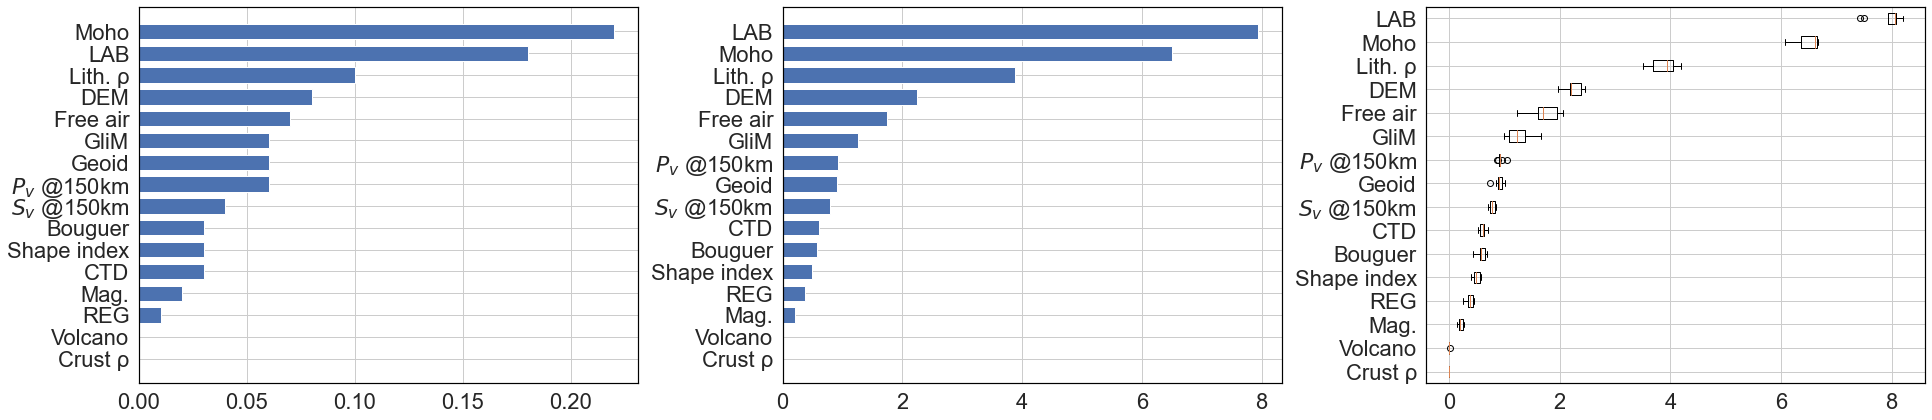

In [17]:
#feature importance 
# Get selected features data set
# should be scaled

sub_figs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

# Set figure size and create barplot
#sns.set(style="whitegrid", color_codes=True, font_scale = 1.8)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27, 6))

plt.rcParams.update(plt_params)



feature_importance = pd.DataFrame()
 

# Load hyper parameter 

numeric_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer(
    transformers=[
           ("num", numeric_transformer, selector(dtype_exclude="category")),
           ("cat", categorical_transformer, selector(dtype_include="category")),
    ], 
    #remainder='passthrough', verbose_feature_names_out=False
)


regressor = RandomForestRegressor(random_state=RANDOM_STATE)


steps=[("preprocessor", preprocessor), 
       #("regressor", regressor), 
       ('ttr', TransformedTargetRegressor(regressor=regressor, transformer=numeric_transformer))
      ]

# Initialize Pipeline object
pipeline = Pipeline(steps=steps)

pipeline.set_params(**best_params)


pipeline.fit(X_afr,y_afr)


#####

feature_importance["RI"] = pipeline['ttr'].regressor_.feature_importances_.round(2)
feature_importance["LABELS"]= obs.loc[features , 'LABELS'].values
feature_importance["OBS_REF"] = obs.index
feature_importance.set_index('LABELS', inplace=True)


permutaion_ranking = permutation_importance(pipeline, X_afr, y_afr, n_repeats=10,
                                    scoring=rmse_score, random_state=RANDOM_STATE)
perm_sorted_idx = permutaion_ranking.importances_mean.argsort()


obs.reset_index(drop=False).set_index('OBS_REF', inplace=True)

# Get feature importance


# Get feature importance
feature_importance["PFI"] = permutaion_ranking.importances_mean


feature_importance = feature_importance.sort_values(by="RI", ascending=True)
ax1.barh(feature_importance.index, feature_importance['RI'], height=0.7)


feature_importance = feature_importance.sort_values(by="PFI", ascending=True)
ax2.barh(feature_importance.index, feature_importance['PFI'], height=0.7)

ax3.boxplot(
    permutaion_ranking.importances[perm_sorted_idx].T,
    vert=False,
    labels=obs.loc[X_afr.iloc[:,perm_sorted_idx].columns , 'LABELS'].values,
)



# Tight layout
plt.tight_layout()

plt.show()

#fig.savefig(DIR/'fig'/f"fig_8_PFI_rab.jpg", bbox_inches='tight', dpi=300 )


# Save Figure
#fig.savefig(dir_p/ 'fig'/"fig_5.jpeg", bbox_inches='tight', dpi=300 )

In [23]:
# individual RFECV to calculate conribution of each feature to R2 and NRMSe

for feature in obs.index:

    print(feature)


    X_train_afr_feature = X_afr[feature].to_frame()

    numeric_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    preprocessor = ColumnTransformer(
        transformers=[
               ("num", numeric_transformer, selector(dtype_exclude="category")),
               ("cat", categorical_transformer, selector(dtype_include="category")),
        ], 
        #remainder='passthrough', verbose_feature_names_out=False
    )


    regressor = RandomForestRegressor(random_state=RANDOM_STATE)

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.

    steps=[("preprocessor", preprocessor), 
           #("regressor", regressor), 
           ('ttr', TransformedTargetRegressor(regressor=regressor, transformer=numeric_transformer))
          ]

    # Initialize Pipeline object
    pipeline = Pipeline(steps=steps)

    pipeline.set_params(**best_params)



    for key, score in scorings.items():
        feature_importance.loc[obs.loc[feature, 'LABELS'], key] = np.mean(cross_validate(
            pipeline, 
            X_train_afr_feature, 
            y_afr,
            scoring=score,
              cv=CV)['test_score'])


feature_importance[['RI', 'PFI', 'NRMSe', 'R2']] = feature_importance[['RI', 'PFI', 'NRMSe', 'R2']].abs() 

print('terminated')

CTD
SI
LAB
MOHO
SV
PV
GEOID
DEM
FA
BG
EMAG2_CLASS
RHO_L
RHO_C
VOLC_DIST_W
REG
GLIM
terminated


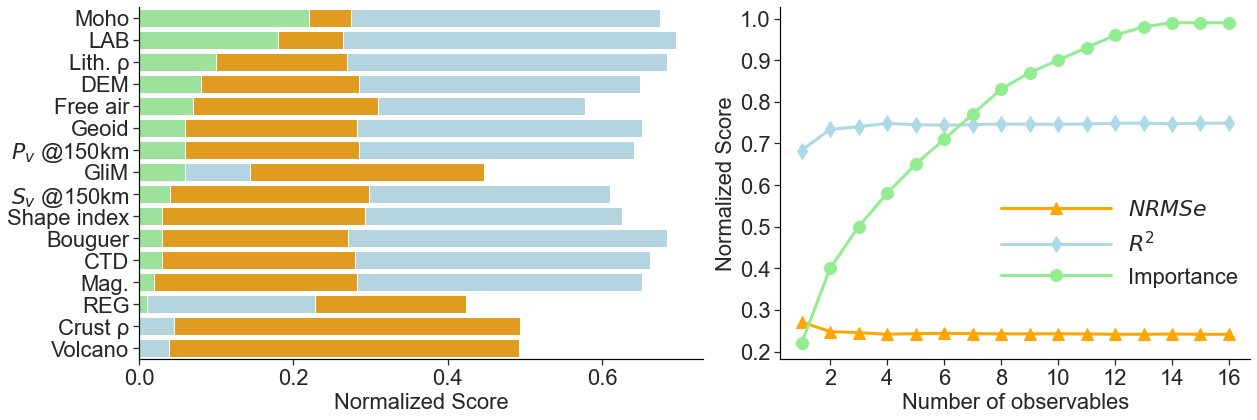

In [24]:
feature_importance = feature_importance.sort_values(by="RI", ascending=False)

feature_importance["CUMSUM"] = feature_importance["RI"].cumsum()
score_progression["CUMSUM"] = feature_importance["CUMSUM"].values

mask_RV_NRMSE = (feature_importance['RI'] < feature_importance['NRMSe']) & (feature_importance['NRMSe'] < feature_importance['R2'])

mask_NRMSE_RV = (feature_importance['NRMSe'] < feature_importance['RI']) & (feature_importance['RI'] < feature_importance['R2']) 
    
mask_R2_RV = (feature_importance['R2'] < feature_importance['RI']) & (feature_importance['RI'] < feature_importance['NRMSe'])


mask_RV_R2 = (feature_importance['RI'] < feature_importance['R2']) & (feature_importance['R2'] < feature_importance['NRMSe'])

mask_NRMSE_R2 = (feature_importance['NRMSe'] < feature_importance['R2']) & (feature_importance['R2'] < feature_importance['RI']) 


mask_R2_NRMSE = (feature_importance['R2'] < feature_importance['NRMSe']) & (feature_importance['NRMSe'] < feature_importance['RI'])



#feature importance 
# Get selected features data set
# should be scaled
fig, axes = plt.subplots(1,2, figsize=(18,6),gridspec_kw={'width_ratios': [3, 2.5]})
sns.set(style="whitegrid")





axes.ravel()
#sns.set(style="whitegrid", color_codes=True, font_scale = 3)



###1
if mask_RV_NRMSE.any():
    sns.barplot(x = feature_importance['R2'].values * mask_RV_NRMSE.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance['NRMSe'].values * mask_RV_NRMSE.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    sns.barplot(x = feature_importance["RI"].values * mask_RV_NRMSE.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

###2
if mask_NRMSE_RV.any():
    sns.barplot(x = feature_importance['R2'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance["RI"].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

    sns.barplot(x = feature_importance['NRMSe'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    

###3
if mask_R2_RV.any():
    sns.barplot(x = feature_importance['NRMSe'].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )


    sns.barplot(x = feature_importance["RI"].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )


    
    sns.barplot(x = feature_importance['R2'].values * mask_R2_RV.astype(int).values, 
            y = feature_importance.index, 
            ax=axes[0], color='lightblue',
            )
    

###4
if mask_RV_R2.any():
    
    sns.barplot(x = feature_importance['NRMSe'].values * mask_RV_R2.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    
    sns.barplot(x = feature_importance['R2'].values * mask_RV_R2.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )

    sns.barplot(x = feature_importance["RI"].values * mask_RV_R2.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

###5
    
if mask_NRMSE_RV.any():
    sns.barplot(x = feature_importance['R2'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance["RI"].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

    sns.barplot(x = feature_importance['NRMSe'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    
####6
if mask_R2_RV.any():
    
   
    sns.barplot(x = feature_importance['NRMSe'].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    sns.barplot(x = feature_importance["RI"].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )
    
    sns.barplot(x = feature_importance['R2'].values * mask_R2_RV.astype(int).values, 
            y = feature_importance.index, 
            ax=axes[0], color='lightblue',
            )
    
    
### optimal

'''
if mask_RV_NRMSE.any():
    sns.barplot(x = feature_importance.loc[mask_RV_NRMSE[0:11], 'R2'].values, 
                y = feature_importance.loc[mask_RV_NRMSE[0:11], 'R2'].index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance.loc[mask_RV_NRMSE[0:11],'NRMSe'].values, 
                y = feature_importance.loc[mask_RV_NRMSE[0:11],'NRMSe'].index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    sns.barplot(x = feature_importance.loc[mask_RV_NRMSE[0:11],"RI"].values, 
                y = feature_importance.loc[mask_RV_NRMSE[0:11],"RI"].index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )
    
''' 


axes[0].set_ylabel('')
axes[0].grid(False)



#axes[0].patch.set_edgecolor('black')  
#axes[0].patch.set_linewidth('3') 
# Hide the right and top spines
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')





axes[0].locator_params(axis='x', nbins=7)
#axes[0].legend(loc=[.55, .6], framealpha=0.5)

#axes[0].set_title(f'{sub_figs[0]})', loc ='left', pad=20, size=40,  y=1.1)
axes[0].set_xlabel("Normalized Score")

markersize = 12
linewidth = 3
for key, score in scorings.items():
    #selected_features = feature_names[results[key].support_].tolist()
    # Get Performance Data
    #print(f"Optimal number of features for {key} : {results[key].n_features_}")
    if key == 'NRMSe':
        #results[key].support_rfecv_df = pd.DataFrame(results[key].ranking_,index=X_afr_lr.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)

        axes[1].plot(score_progression.index, 
                 score_progression['NRMSe_RFECV'], color='orange', linewidth=linewidth,
                   marker="^", label='$NRMSe$', markersize=markersize,)


    else:
        axes[1].plot(score_progression.index,
                 score_progression['R2_RFECV'], color='lightblue', 
                     linewidth=linewidth, marker="d",  label='$R^2$', markersize=markersize,
                       )


axes[1].plot(score_progression.index, 
         score_progression['CUMSUM'], linewidth=linewidth, 
            color='lightgreen',  marker="o", 
             label=f'''Importance''', markersize=markersize,)


axes[1].set_xlabel("Number of observables")

axes[1].set_ylabel("Normalized Score")
axes[1].legend(loc=[.45, .18], frameon=False, fontsize=22, )
#axes[1].legend(loc=[.01, .7])
#plt.axesvline(results[key].n_features_ ,color='r')
#axes[1].set_title(f'{sub_figs[1]})', loc ='left', pad=20, size=40,  y=1.1)
axes[1].locator_params(axis='y', nbins=10)
axes[1].locator_params(axis='x', nbins=9)
axes[1].grid(False)

axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')


plt_params = {
    #'figure.titlesize' : 28,
    "axes.titlesize" : 22, # main
    "axes.labelsize" : 22,  # labels
    "axes.edgecolor" : "black", 
    "axes.linewidth" : 1.2, 
    'xtick.labelsize': 22, # ticks
    'ytick.labelsize': 22,
    #'legend.fontsize': 20,
     'legend.handlelength': 5,
    #'legend.title_fontsize':5,
    #'legend.fontsize': 5,
    #'font.size': 18,
}

plt.rcParams.update(plt_params)

# Tight layout
plt.tight_layout()


# Save Figure
#fig.savefig(dir_p/'fig'/'presentation'/"fig_p6d.jpeg", bbox_inches='tight', dpi=300 )
#fig.savefig(DIR/'fig'/"fig_8.pdf", bbox_inches='tight', dpi=300 )
#fig.savefig(DIR/'fig'/"fig_8.jpg", bbox_inches='tight', dpi=300 )

####




# Modeling

In [25]:
#target values
AFR_grid = pd.DataFrame({'X': ds_afr.XV.values.ravel(), 'Y': ds_afr.YV.values.ravel()})
for feature in tqdm_notebook(features ,  desc=f'Processing: ', leave=False ):
    sleep(0.01)
    AFR_grid[feature] = ds_afr[feature].values.ravel()

AFR_grid['GLIM']  = AFR_grid['GLIM'].astype('int').astype('category')
AFR_grid['REG']  = AFR_grid['REG'].astype('int').astype('category')
AFR_grid

Processing:   0%|          | 0/16 [00:00<?, ?it/s]

X     Y        CTD        SI         LAB       MOHO        SV        PV      GEOID     DEM          FA          BG  EMAG2_CLASS        RHO_L        RHO_C  VOLC_DIST_W REG GLIM
0     -20.000000 -37.0  22.684706  0.475390   73.675776  13.511503 -0.031900 -0.002000  19.500100 -3960.0   22.469700  240.800500    -0.029365  3295.735664  2890.586195          0.0   4   16
1     -19.492958 -37.0  22.684779  0.398090   73.432863  13.388837 -0.031149 -0.001993  19.908145 -3459.0   14.771557  243.298533     0.030536  3289.616913  2867.198641          0.0   4   16
2     -18.985915 -37.0  22.684841  0.197068   73.471736  13.259348 -0.030675 -0.001897  20.322071 -2739.0   14.693079  238.876632     0.019824  3282.788825  2855.305174          0.0   4   16
3     -18.478873 -37.0  22.684895 -0.381547   73.523591  13.153260 -0.030296 -0.001805  20.742455 -3015.0   17.642908  228.090904     0.058894  3285.510670  2850.283302          0.0   4   16
4     -17.971831 -37.0  22.684940 -0.651345   73.443809  13.092266 -0.029906 -0.001691  21.140521 -2839.0   11.427763  222.969480     0.017579  3284.703277  2837.854356          0.0   4   16
...          ...   ...        ...       ...         ...        ...       ...       ...        ...     ...         ...         ...          ...          ...          ...          ...  ..  ...
21302  49.971831  38.0  30.760660  0.684652  104.314448  44.283931  0.014225 -0.000793  -7.867484  -615.0 -107.737616  -65.665522    -1.000000  3276.623103  2742.361647          0.0   3   11
21303  50.478873  38.0  31.247129  0.736723  105.842634  44.072531  0.020235  0.000325  -8.104729  -821.0  -58.138908  -34.068873    -1.000000  3279.377990  2750.265085          0.0   3   11
21304  50.985915  38.0  31.577215  0.775641  115.780705  43.967444  0.025897  0.002209 -11.846222  -817.0  -70.484295  -22.683148    -1.000000  3280.837388  2752.004463          0.0   3   11
21305  51.492958  38.0  31.974282  0.798024  117.915130  43.927094  0.031653  0.003105 -11.750301  -796.0  -59.834318  -25.597906    -1.000000  3280.214942  2751.765276          0.0   3   11
21306  52.000000  38.0  31.310743  0.790250  120.238280  43.954340  0.038300  0.003600 -12.515800  -655.0  -36.628400   -9.459800    -1.000000  3278.253246  2750.312005          0.0   3   11

[21307 rows x 18 columns]

In [27]:
RANDOM_STATE = 42
pipeline_dict = {}
grid_dict = {}
best_features = [ 16, 15, 14, 13, 12, 11,10,
                 9,8,7,6,5,4
                 ]

labels = ['RFE_16', 'RFE_15', 'RFE_14', 'RFE_13', 'RFE_12', 'RFE_11', 'RFE_10', 'RFE_09', 'RFE_08', 'RFE_07', 
    'RFE_06', 'RFE_05', 'RFE_04', 
]

#tuned_params = {item.replace('ttr__regressor__', 'ttr__regressor__estimator__'): best_params[item] for item in best_params}

for best_feature, label in tqdm_notebook(
    zip(best_features, labels), total=len(labels), desc='Training: '):
    
    print(best_feature)
    
    # this step gurantee consistency in feature ranking
    feature_importance.sort_values(by="RI", ascending=False, inplace=True)
    features_reduced = feature_importance['OBS_REF'].values[0:best_feature]
    
    numeric_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    preprocessor = ColumnTransformer(
        transformers=[
               ("num", numeric_transformer, selector(dtype_exclude="category")),
               ("cat", categorical_transformer, selector(dtype_include="category")),
        ], 
        #remainder='passthrough', verbose_feature_names_out=False
    )


    regressor = RandomForestRegressor(random_state=RANDOM_STATE)


    steps=[("preprocessor", preprocessor), 
           #("regressor", regressor), 
           ('ttr', TransformedTargetRegressor(regressor=regressor, transformer=numeric_transformer))
          ]

    # Initialize Pipeline object
    pipeline = Pipeline(steps=steps)

    pipeline.set_params(**best_params)


  
    trained_model = pipeline.fit(X_afr[features_reduced], y_afr )
    
   

    ######### save

   
    pipeline_dict[f'{label}'] = trained_model
    grid_dict[f'{label}'] = AFR_grid[features_reduced]
    

    print(f'RFE_{best_feature} fitting is terminated' )


Training:   0%|          | 0/13 [00:00<?, ?it/s]

16
RFE_16 fitting is terminated
15
RFE_15 fitting is terminated
14
RFE_14 fitting is terminated
13
RFE_13 fitting is terminated
12
RFE_12 fitting is terminated
11
RFE_11 fitting is terminated
10
RFE_10 fitting is terminated
9
RFE_9 fitting is terminated
8
RFE_8 fitting is terminated
7
RFE_7 fitting is terminated
6
RFE_6 fitting is terminated
5
RFE_5 fitting is terminated
4
RFE_4 fitting is terminated


In [28]:
feature_importance.sort_values(by="RI", ascending=False, inplace=True)
RF_features_df = pd.DataFrame({'Labels':feature_importance.index})
RF_features_df['FI'] = feature_importance['RI'].values

for key in pipeline_dict.keys(): 
    RF_features_df[f'{key}'] = pd.Series(pipeline_dict[key]['ttr'].regressor_.feature_importances_).round(2).sort_values()
RF_features_df

Labels    FI  RFE_16  RFE_15  RFE_14  RFE_13  RFE_12  RFE_11  RFE_10  RFE_09  RFE_08  RFE_07  RFE_06  RFE_05  RFE_04
0           Moho  0.22    0.20    0.24    0.21    0.25    0.27    0.28    0.31    0.32    0.35    0.40    0.43    0.44    0.47
1            LAB  0.18    0.18    0.17    0.21    0.18    0.19    0.20    0.20    0.21    0.22    0.18    0.16    0.18    0.25
2        Lith. ρ  0.10    0.10    0.10    0.10    0.11    0.10    0.10    0.10    0.11    0.11    0.13    0.14    0.15    0.17
3            DEM  0.08    0.09    0.08    0.08    0.07    0.07    0.07    0.06    0.06    0.05    0.04    0.05    0.06    0.11
4       Free air  0.07    0.07    0.07    0.06    0.07    0.07    0.08    0.08    0.09    0.10    0.12    0.12    0.17     NaN
5          Geoid  0.06    0.07    0.06    0.07    0.07    0.06    0.07    0.08    0.08    0.09    0.09    0.10     NaN     NaN
6   $P_v$ @150km  0.06    0.06    0.06    0.05    0.05    0.05    0.05    0.04    0.04    0.04    0.05     NaN     NaN     NaN
7           GliM  0.06    0.04    0.04    0.04    0.04    0.03    0.04    0.04    0.04    0.04     NaN     NaN     NaN     NaN
8   $S_v$ @150km  0.04    0.03    0.03    0.03    0.03    0.03    0.03    0.03    0.04     NaN     NaN     NaN     NaN     NaN
9    Shape index  0.03    0.03    0.03    0.03    0.03    0.04    0.04    0.05     NaN     NaN     NaN     NaN     NaN     NaN
10       Bouguer  0.03    0.04    0.03    0.03    0.04    0.04    0.05     NaN     NaN     NaN     NaN     NaN     NaN     NaN
11           CTD  0.03    0.02    0.02    0.02    0.03    0.05     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
12          Mag.  0.02    0.00    0.00    0.06    0.05     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
13           REG  0.01    0.00    0.06    0.01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
14       Crust ρ  0.00    0.06    0.01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
15       Volcano  0.00    0.01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN

In [30]:
predictions_df = {}
xs = range(len(ds_afr.X))
ys = range(len(ds_afr.Y))
nn = (len(ds_afr.Y), len( ds_afr.X))


hq_gt = Afr_OD_ra[[grid_index_afr, target]].set_index(grid_index_afr)
hq_gt.index.names = ['index']

for key, pipeline  in tqdm_notebook(pipeline_dict.items() , 
                                            desc=f'Modelling: '):
    print(key)
    pipeline = pipeline_dict[key]
    AFR_grid = grid_dict[key]
    AFR_Q_RFR = np.zeros(nn) # predicted HF value
    predictions_df[key] = pd.DataFrame({'X': ds_afr.XV.values.ravel(), 'Y': ds_afr.YV.values.ravel()})

    predictions_df[key]['Prediction'] = pipeline.predict(AFR_grid).reshape(-1,1)
    predictions_df[key].index.names = ['index']
    final_df = pd.merge(predictions_df[key], hq_gt,  how="left", on="index")
    final_df.to_csv(DIR/'Grids'/'Outputs'/f'{key}_rab.xyz' , index=False, header=True, sep='\t')
    ds_afr[key] = (('Y', 'X'), predictions_df[key]['Prediction'].values.reshape(nn) )
    
ds_afr.to_netcdf(DIR/'Grids'/'Outputs'/"ds_afr_ra.nc", mode='w', 
                    engine='netcdf4')

Modelling:   0%|          | 0/13 [00:00<?, ?it/s]

RFE_16
RFE_15
RFE_14
RFE_13
RFE_12
RFE_11
RFE_10
RFE_09
RFE_08
RFE_07
RFE_06
RFE_05
RFE_04


In [31]:
for label in labels:
    diff = ds_afr['RFE_16'] - ds_afr[label]
    print(f'Difference between 16 and {label}: {np.round(diff.mean(), 2)}')
print('##'*10)  
for label in labels:
    diff = ds_afr['RFE_11'] - ds_afr[label]
    print(f'Difference between 11 and {label}: {np.round(diff.mean(), 2)}')

Difference between 16 and RFE_16: 0.0
Difference between 16 and RFE_15: -0.53
Difference between 16 and RFE_14: 0.59
Difference between 16 and RFE_13: 0.72
Difference between 16 and RFE_12: 1.06
Difference between 16 and RFE_11: 1.19
Difference between 16 and RFE_10: -0.44
Difference between 16 and RFE_09: -0.91
Difference between 16 and RFE_08: -1.45
Difference between 16 and RFE_07: -1.45
Difference between 16 and RFE_06: -1.97
Difference between 16 and RFE_05: -1.9
Difference between 16 and RFE_04: 4.07
####################
Difference between 11 and RFE_16: -1.19
Difference between 11 and RFE_15: -1.72
Difference between 11 and RFE_14: -0.6
Difference between 11 and RFE_13: -0.48
Difference between 11 and RFE_12: -0.13
Difference between 11 and RFE_11: 0.0
Difference between 11 and RFE_10: -1.63
Difference between 11 and RFE_09: -2.1
Difference between 11 and RFE_08: -2.64
Difference between 11 and RFE_07: -2.64
Difference between 11 and RFE_06: -3.16
Difference between 11 and RFE_0

# RFECV

In [32]:
sub_figs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

#create two datsets for A ratibng and b ratings
hq_f = DIR / 'Dataset'/ 'References'/'q_Heat_Flow'/'NGHF.csv'

elev_cut = -1000

record_total = pd.read_csv(hq_f)

record_total = record_total.rename(columns={'heat-flow (mW/m2)': target, 'longitude': 'lon', 'latitude': 'lat'})




hq_afr_lat = record_total[record_total['lat'].between(afr_lat_min, afr_lat_max, inclusive='both')]
record_total_afr = hq_afr_lat[hq_afr_lat['lon'].between(afr_lon_min, afr_lon_max, inclusive='both')]



hq_no_pole_afr = record_total_afr.dropna(subset = ['lon', 'lat', target])

hq_no_pole_afr = hq_no_pole_afr[hq_no_pole_afr[target].between(hq_lower_bound, hq_upper_bound, inclusive='both')]


#hq_no_pole_afr = hq_clean[hq_clean['lat'].between(world_lat_min, world_lat_max, inclusive='both')]
hq_deep_afr = hq_no_pole_afr[(hq_no_pole_afr['elevation (m)']>elev_cut)][['lon', 'lat',target]]



hq_final_a_afr = hq_no_pole_afr[(hq_no_pole_afr ['code6']=='A') & (hq_no_pole_afr ['elevation (m)']>elev_cut)][['lon', 'lat',target]]
hq_final_b_afr= hq_no_pole_afr[(hq_no_pole_afr ['code6']=='B') & (hq_no_pole_afr ['elevation (m)']>elev_cut)][['lon', 'lat',target]]





In [33]:
Best_feature = 11

obs = obs.reset_index(drop=False).set_index('LABELS')

reduced_datsets = obs.loc[feature_importance.iloc[0:Best_feature, 0].index, :]
reduced_datsets = reduced_datsets.reset_index()




obs = obs.reset_index(drop=False).set_index('OBS_AFR')

reduced_datsets

LABELS OBS_REF      OBS_AFR   LABELS_gmt            UNITS  UNITS_gmt          V_RANGE      V_RANGE_AFR            CMAPS
0           Moho    MOHO         MOHO         Moho               km         km         (15, 60)         (20, 50)       SCM/bamako
1            LAB     LAB          LAB          LAB               km         km         (0, 300)        (50, 250)       SCM/bamako
2        Lith. ρ   RHO_L        RHO_L    Lith. rho         kg/m$^3$  kg/m@+3@+     (3260, 3360)     (3260, 3360)       SCM/batlow
3            DEM     DEM          DEM          DEM                m          m    (-2200, 2200)    (-2200, 2200)       SCM/oleron
4       Free air      FA           FA     Free air             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc
5          Geoid   GEOID        GEOID        Geoid                m          m        (-45, 45)        (-45, 45)       SCM/bamako
6   $P_v$ @150km      PV  PV_Velocity  P@_v@ 150km  $\delta$$P_v$ %       km/s    (-0.02, 0.02)    (-0.02, 0.02)         SCM/roma
7           GliM    GLIM         GLIM         GliM            class      class          (1, 16)          (1, 15)  gmt/categorical
8   $S_v$ @150km      SV  SV_Velocity  S@_v@ 150km  $\delta$$S_v$ %       km/s  (-0.075, 0.075)  (-0.075, 0.075)         SCM/roma
9    Shape index      SI           SI  Shape index               si         si          (-1, 1)          (-1, 1)         SCM/broc
10       Bouguer      BG           BG      Bouguer             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc

In [35]:


#proj=f"l135/-25/-45/-10/2c"
region_gmt= [afr_lon_min, afr_lon_max,afr_lat_min, afr_lat_max]
projection = 'M5.4i'


frames = ['wNes', 'wNes','wNEs','Wnes', 'wnes', 'wnes','wnEs','WneS', 'wneS', 'wneS','wnES','wnES']

fig = pygmt.Figure()

pygmt.config(FONT='25p')

with fig.subplot(
    nrows=6,
    ncols=4,
    #figsize=("30c", "15c"),  # width of 15 cm, height of 6 cm
    subsize = ("13.5c", "13.5c"),
    autolabel=['A)+o0.3/-1.5'],
    margins=["0.3c", "2.7c"],  # horizontal 0.3 cm and vertical 0.2 cm margins
    #title=model[3:],
    #sharex="bt",  # shared x-axis on the bottom side
    sharey=True,  # shared y-axis on the left side
    #frame="WSrt",
):

    with fig.set_panel(panel=0):

        cmap = pygmt.makecpt(
                cmap=DIR/'GMT'/'temperature.cpt', #temp 19lev
            #cmap='lajolla',
                series='30/130',
                #truncate = '40/140',
                #continuous=True,
                reverse=False,
            )

        fig.basemap(region=region_gmt, projection=projection, frame='WNes', panel=0)

      


        fig.coast(
            projection=projection,
            #shorelines=0.5,
            water="lightblue", 
            shorelines="0.1p,black",
            borders=["1/0.001p,black"],
            lakes="lightblue",
            rivers="lightblue" ,
            land='darkgrey'
            #borders=["1/0.5p,black"],
            #water='white',
            
            )

        fig.plot(x=Afr_OD_ra.lon, y=Afr_OD_ra.lat,  cmap=True, projection=projection,
             color=Afr_OD_ra[target], #label=f"'A Rating'",
                      pen="0.01p,darkgrey", style="c0.21c")

        fig.colorbar(frame=["af", f"x+lGHF\t\t[mW/m@+2@+]"], 
                     position=f"g{str(afr_lon_min-1)}/{str(afr_lat_min-8.2)}+w12.5c/0.5c+h+e")
    

    for  cmap_i, grid_label_i, v_range_i, label_i ,unit_i, importance, panel,  in zip(
         reduced_datsets['CMAPS'],  reduced_datsets['OBS_AFR'],
                    reduced_datsets['V_RANGE_AFR'], reduced_datsets['LABELS_gmt'],
        reduced_datsets['UNITS_gmt'], feature_importance['RI'],
        list(range(len(reduced_datsets)))):

        
        with fig.set_panel(panel=panel+1):
            if cmap_i =='bilbao':
                pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range_i[0]}/{v_range_i[1]}',
                #continuous=True,
                reverse=True,
                )
            elif grid_label_i in ['REG', 'GLIM']:
                pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range_i[0]}/{v_range_i[1]}/1',
                #categorical=True,
                #continuous=True,
                )
            elif grid_label_i in ['SV_Velocity', 'PV_Velocity']:
                pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{ds_afr[grid_label_i].min().values}/{ds_afr[grid_label_i].max().values}',
                #continuous=True,
                reverse=False,
                )
            elif grid_label_i == 'EMAG2':
                pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range_i[0]}/{v_range_i[1]}',
                #continuous=True,
                reverse=False,
                )
            else:
                pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range_i[0]}/{v_range_i[1]}',
                #continuous=True,
                reverse=False,
                )
                

            fig.basemap(region=region_gmt, projection=projection, frame=frames[panel], panel=panel+1)



            fig.grdimage(
                 grid=ds_afr[grid_label_i], # xarray.DataArray containing VSV values
                 region=region_gmt,
                 projection=projection,
                     cmap=cmap,

                #shading='+a45+nt0.5'
                #shading=dgrid
            )





            fig.coast(
                projection=projection,
                #shorelines=0.5,
                water="lightblue", 
                shorelines="0.1p,black",
                borders=["1/0.001p,black"],
                lakes="lightblue",
                rivers="lightblue" ,
                #borders=["1/0.5p,black"],
                #water='white',
                )

            #print(f'{importance} {label_i}')
            #fig.colorbar(frame=["af", f'x+l"{label_i}"\t\t"[{unit_i}]"\t\t({str(round(importance*100,1))}\%)',
            fig.colorbar(frame=["af", f'x+l"{label_i}"\t\t"[{unit_i}]"',                           ],
                    position=f"g{str(afr_lon_min-1)}/{str(afr_lat_min-8.2)}+w12.5c/0.5c+h+e")
            

 

fig.show(width=800)


#fig.savefig(DIR/'fig'/"fig_3.pdf", dpi=300 )
#fig.savefig(DIR/'fig'/"fig_3.jpg", dpi=300 )

grdimage [WARNING]: Your CPT is categorical. Enabling -nn+a to avoid interpolation across categories.
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorical value - returning NaN color
grdimage [WARNING]: Requested color lookup for z = 16 is not a categorica

colorbar [WARNING]: Option -D: Cannot select back/fore-ground extender for categorical CPT
